In [3]:
from joblib import dump, load
import numpy as np
import cv2
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

In [4]:
#import the clustered ds swatches
hsv_knn = load('ds_h_knn_3.joblib')

# Validation steps
1. import an image made from five swatches of ds paints
2. collect the hsv and shifted HSV values
3. Drop the neutral tones
4. Cluster on K-means++ and collect the top 5 clusters
5. Match those clusters to the hsv_knn model

## Import the test image
goldfinch

In [6]:
img = cv2.imread('/Users/macbook/Box/insight_project_data/test_image/tucan2.jpg')

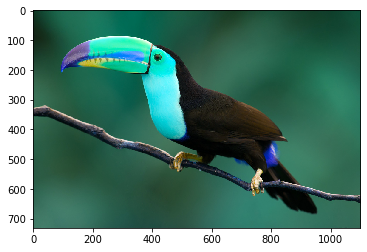

In [7]:
#don't forget it is in brg
plt.imshow(img)

In [8]:
#convert to hsv
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


In [9]:
#convert to pixels
pixels = np.float32(img_HSV.reshape(-1, 3))

In [10]:
def shift_h_remove(data, v_thresh, s_thresh):
    """Produces shifted H values for color segmentation and removed neutral tones
    Inputs: data - list of pixel H, S, V values one entry per pixel
    Outputs: H, H120, H240
    """
    shifted_colors = []
    for i in range(0,len(data)):
        H = data[i][0]
        s = data[i][1]
        v = data[i][2]
        V_thres = 255*v_thresh
        S_thres = 255*s_thresh
        if (v > V_thres and s > S_thres):
            if H >= 120:
                H120 = H - 120
            else:
                H120 = H + 60
            if H >= 60:
                H240 = H - 60
            else:
                H240 = H + 120
            shifted_colors.append([H, H120, H240, s, v])        
        else:
           pass
        
        
    return shifted_colors

In [11]:
def shift_h_split(data, v_thresh, s_thresh):
    """Produces shifted H values for color segmentation and removed neutral tones
    Inputs: data - list of pixel H, S, V values one entry per pixel
    Outputs: H, H120, H240
    """
    shifted_colors = []
    shifted_neutrals = []
    for i in range(0,len(data)):
        H = data[i][0]
        s = data[i][1]
        v = data[i][2]
        V_thres = 255*v_thresh
        S_thres = 255*s_thresh
        if (v > V_thres and s > S_thres):
            label = "c"
            if H >= 120:
                H120 = H - 120
            else:
                H120 = H + 60
            if H >= 60:
                H240 = H - 60
            else:
                H240 = H + 120
            shifted_colors.append([H, H120, H240, s, v, label])        
        else:
            label = "n"
            H = H
            H120 = H + 200
            H240 = H + 200
            shifted_neutrals.append([H, H120, H240, s, v, label])
        
        
    return shifted_colors, shifted_neutrals

In [31]:
pixels_split_c, pixels_split_n = shift_h_split(pixels, .25, .25)

In [32]:
pixels_shift = shift_h_remove(pixels, .25, .25)

In [33]:
pixels_shift[0]

[42.0, 102.0, 162.0, 183.0, 64.0]

In [751]:
len(pixels)

172800

In [752]:
len(pixels_shift)

145714

In [34]:
pixels_df_c = pd.DataFrame(pixels_split_c, columns=['h','H120','H240','s','v','label'])

In [35]:
X_pixels = pixels_df_c[['h']]

In [36]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=42, algorithm = 'full')
kmeans.fit(X_pixels)
image2show = kmeans.cluster_centers_[kmeans.labels_]

In [37]:
kmeans_df = pd.DataFrame(image2show, columns=['h'])

In [38]:
kmeans_df['label'] = kmeans.labels_

In [39]:
kmeans_df.groupby('label').mean()

,h
label,
0,38.450598
1,102.350218
2,172.157842
3,10.351687
4,46.953147
5,29.108937
6,42.195194
7,85.310486


In [40]:
kmeans_df.label.value_counts()

6    314318
0    206650
4    108382
5     30302
3     11442
1      8015
2      3966
7      3166
Name: label, dtype: int64

In [41]:
kmeans_top = kmeans_df[(kmeans_df['label'] == 5) | (kmeans_df['label'] == 14)| (kmeans_df['label'] == 0)| (kmeans_df['label'] == 17)| (kmeans_df['label'] == 16)| (kmeans_df['label'] == 3)| (kmeans_df['label'] == 11)| (kmeans_df['label'] == 12)| (kmeans_df['label'] == 8)]

In [42]:
kmeans_top.label.value_counts()

0    206650
5     30302
3     11442
Name: label, dtype: int64

In [43]:
X = kmeans_df[['h']]

In [44]:
predict_colors = hsv_knn.predict(X)

In [45]:
colors2 = np.array(np.unique(predict_colors, return_counts=True)).T

In [46]:
colors2[:,0]

array(['Cobalt Teal Blue', 'Lemon Yellow', 'Perinone Orange',
       'Prussian Blue', 'Quinacridone Rose', 'Sap Green'], dtype=object)

In [974]:
colors2df = pd.DataFrame(colors2, columns = ['name', 'count'])

In [975]:
names = colors2df.sort_values(by=['count'], ascending = False)

In [976]:
names_top = names[names["count"] > 1000]

In [977]:
names_top

,name,count
2,Hooker’s Green,26258
0,Alizarin Crimson,17397
4,Sap Green,10837
3,Quinacridone Coral,3855
1,Hansa Yellow Medium,3332


In [956]:
j = ''

In [957]:
for i in range(0,len(names_top)):
    j += str(names_top.name[i]) + "; "
               

In [958]:
j

'Cadmium Yellow Light Hue; Phthalo Blue Red Shade; Phthalo Green Yellow Shade; Quinacridone Coral; Quinacridone Red; Sap Green; Shadow Violet; '

In [889]:
kmeans.cluster_centers_

array([[ 43.30854256],
       [  7.68678839],
       [ 34.43389365],
       [ 17.48340492],
       [ 47.38060202],
       [  3.85151758],
       [ 39.99298131],
       [178.04347826]])

In [890]:
colors = np.array(np.unique(kmeans.labels_, return_counts=True)).T
print(colors)

[[     0 245629]
 [     1  90201]
 [     2  57468]
 [     3  17927]
 [     4 125178]
 [     5  61051]
 [     6 150598]
 [     7     23]]


In [861]:
kmeans.labels_

array([5, 5, 5, ..., 5, 5, 5], dtype=int32)

# Start HERE

In [327]:
hsv_knn2 = load('ds_h_knn_2.joblib')

In [891]:
predict_colors = hsv_knn.predict(X_pixels)

In [892]:
predict_colors

array(['Sap Green', 'Sap Green', 'Sap Green', ..., 'Sap Green',
       'Sap Green', 'Sap Green'], dtype=object)

In [893]:
colors = np.array(np.unique(predict_colors, return_counts=True)).T

In [894]:
colors

array([['Alizarin Crimson', 7],
       ['Bismuth Vanadate Yellow', 645],
       ['Burnt Umber', 2030],
       ['Cadmium Red Medium Hue', 46],
       ['Cadmium Yellow Light Hue', 661],
       ['Cadmium Yellow Medium Hue', 1235],
       ['Green Gold', 4448],
       ['Hansa Yellow Medium', 1841],
       ['Hooker’s Green', 337],
       ['Indian Yellow', 1059],
       ['Naples Yellow', 1046],
       ['Nickel Azo Yellow', 1442],
       ['Organic Vermilion', 45285],
       ['Perinone Orange', 3932],
       ['Permanent Alizarin Crimson', 13],
       ['Pyrrol Orange', 2504],
       ['Pyrrol Red', 22680],
       ['Pyrrol Scarlet', 18586],
       ['Quinacridone Burnt Scarlet', 22332],
       ['Quinacridone Coral', 49075],
       ['Quinacridone Deep Gold', 3957],
       ['Quinacridone Gold', 1592],
       ['Quinacridone Magenta', 2],
       ['Quinacridone Red', 1],
       ['Quinacridone Sienna', 6567],
       ['Raw Sienna', 1806],
       ['Raw Umber', 1471],
       ['Rich Green Gold', 1427],
     

In [895]:
predictions = pd.DataFrame(colors, columns=["name","pixels"])

In [896]:
predictions.sort_values(by=['pixels'], ascending = False)

,name,pixels
28,Sap Green,521002
19,Quinacridone Coral,49075
12,Organic Vermilion,45285
30,Shadow Violet,28949
16,Pyrrol Red,22680
18,Quinacridone Burnt Scarlet,22332
17,Pyrrol Scarlet,18586
24,Quinacridone Sienna,6567
6,Green Gold,4448
20,Quinacridone Deep Gold,3957
